## Imports

In [21]:
import os
import sys
import pandas as pd
import seaborn as sns

from typing import List, Union
from pydantic import validate_arguments

# Importing functions from src/data
parent_dir = os.path.abspath(os.path.join('..'))
module_path = parent_dir + "/src/data"

if module_path not in sys.path:
    sys.path.append(module_path)

import database as db
import api
import pickle_helpers as pkle
import constants as cnt

## Table of Contents

1. [Data Collection](#data-collection)
2. [Data Validation](#data-validation)
3. [Preprocessing](#preprocessing)

### Data Collection

The average price is collected from an API and stored in a postgresql database. In order to retrieve the data in order to begin any analysis we make a query to the database which is handled by the market_data function below.

The data recieved is in the format of a list of 3-tuples containing a unique id, time and price at that time.

In [22]:
@validate_arguments
def market_data(item_name: str, region_id: str | int = "0", order_type: str = "buy", stat: str = "weightedAverage") -> List:
    """ Makes a query to the postgresql database market_data based on the parameters specified.

    Args:
        item_name (str): Provide the name of the raw material,
        
        region_id (str, int): Select region id of the market data. defaults to "0".
        
            - There are 7 Regions
                - Global - 0
                - Jita - 30000142
                - Perimeter - 30000144
                - Jita 4-4 CNAP - 60003760
                - Amarr VIII - 60008494
                - Dodixie - 60011866
                - Rens - 60004588
                - Hek - 60005686
                
        order_type (str, optional): Either 'buy' or 'sell' orders. Defaults to "buy".
        
        stat(str): Select the summary statistic to return

            - Valid args for stat:
                - weightedAverage
                - max
                - min
                - stddev
                - median
                - volume
                - orderCount
                - percentile

    Returns:
        List: Contains a list of tuples containing id, time, and data from market_data
    """
    # Validating and reformating arguments into proper format
    order_type = order_type.lower()
    
    itemid = api.get_item_id(item_name)
    
    # Postgresql query unpacking JSON data field
    command = (
        f"""
        SELECT id, time, data -> '{itemid}' -> '{order_type}'
        FROM market_data
        WHERE region_id = {region_id}
        """
        )
    
    results = db.postgresql_command(command, results=True)
    
    return results
    

In [40]:
# TODO: Improve function to follow dry principles
def create_item_dataframe(raw_material_name: str, region_id: str | int = "0"):
    
    # Historical average buy and sell order stats for raw_material_name
    buy_market_stats = market_data(raw_material_name, region_id=region_id)
    buy_order_stats = [i[2] for i in buy_market_stats]
    times = [i[1] for i in buy_market_stats]
    
    sell_market_stats = market_data(raw_material_name, region_id=region_id, order_type="sell")
    sell_order_stats = [i[2] for i in sell_market_stats]
    times = [i[1] for i in sell_market_stats]

    # Creating dataframe for 
    df_buy = pd.DataFrame(data=buy_order_stats)
    df_buy.rename(columns=lambda x: "buy_" + x, inplace=True)
    
    df_sell = pd.DataFrame(data=sell_order_stats)
    df_sell.rename(columns=lambda x: "sell_" + x, inplace=True)
    
    df_times = pd.DataFrame(data=times, columns=["time"])

    df = pd.concat([df_times, df_buy, df_sell], axis=1)

    return df

def create_item_plot(raw_material_name: str):
    
    df = create_item_dataframe(raw_material_name)
    
    # Fixing datatype for all the columns except the time column
    for i in df.iloc[:,1:].columns:
        df[i] = pd.to_numeric(df[i])
        
    df = df[['time', 'buy_median', 'buy_weightedAverage', 'sell_median', 'sell_weightedAverage']]
    data = pd.melt(df, ["time"])
    
    # Plot
    sns.set_theme(style="white")
    plt = sns.lineplot(data=data, x='time', y='value', hue='variable')
    plt.set(title=f"The Price of {raw_material_name}", ylabel="Price (ISK)")
    

Command executed successfully
Command executed successfully


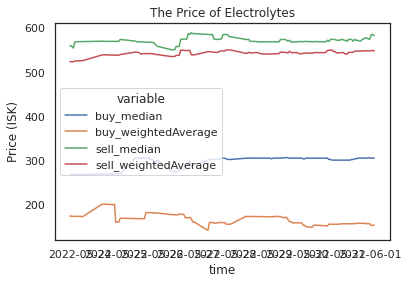

In [47]:
#market_data("Silicon", "0", order_type="sell")
#create_item_dataframe("Silicon", "0")
create_item_plot("Electrolytes")

[Text(0.5, 1.0, 'The Price of Silicon'), Text(0, 0.5, 'Price (ISK)')]

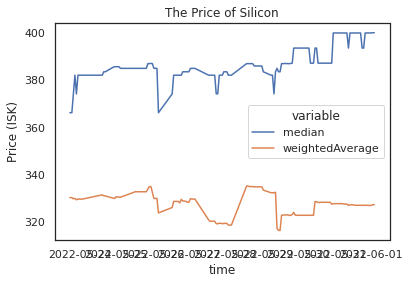

In [28]:
# Plot
sns.set_theme(style="white")
plt = sns.lineplot(data=pd.melt(df_buy[['time', 'median', 'weightedAverage']], ["time"]), x='time', y='value', hue='variable')
plt.set(title="The Price of Silicon", ylabel="Price (ISK)")



In [29]:
# Create function that will generate plots given the name of a raw material